In [1]:
import pyogrio
import pandas as pd
import pickle
from zipfile import ZipFile
import tempfile
import numpy as np
from pathlib import Path
import os
from collections import defaultdict
pd.set_option('display.max_columns',None)

# requires local installation of ireiat package using 
from ireiat.config import CACHE_PATH

### Purpose
Given the FAF5 regional association with counties and the county population, create an OD matrix (state_orig, county_orig, state_dest, county_dest)=tons

In [2]:
TARGET_FIELD = 'tons_2022'
TOLERANCE = 1e-5

In [3]:
county_pop_pdf = pd.read_csv(CACHE_PATH / 'raw/co-est2022-alldata.csv',dtype={'STATE':str,'COUNTY':str})

In [4]:
with open(CACHE_PATH / 'faf_id_to_county_areas','rb') as fp:
    faf_id_to_county_id_map = pickle.load(fp)

In [5]:
actual_state_county_to_pop_map = dict()
for row in county_pop_pdf.loc[county_pop_pdf['COUNTY']!='000'].itertuples(): # ignore state totals
    actual_state_county_to_pop_map[(row.STATE,row.COUNTY)]=row.POPESTIMATE2022

In [6]:
faf_id_to_county_id_population_map = defaultdict(dict)

# look up the county population within each faf zone
for faf_id, vals in faf_id_to_county_id_map.items():
    for (state_id, county_id), pct_county_in_faf in vals.items():
        faf_id_to_county_id_population_map[faf_id][(state_id, county_id)] = actual_state_county_to_pop_map[(state_id, county_id)]*pct_county_in_faf

In [7]:
faf_total_population_map = dict()
for faf_id, vals_dict in faf_id_to_county_id_population_map.items():
    faf_total_population_map[faf_id] = sum(vals_dict.values())

# check that the totals are equal
assert sum(actual_state_county_to_pop_map.values()) == sum(faf_total_population_map.values())

In [8]:
# determine the percentage of the faf demand that should be allocated to the county based on the allocation metric of interest
faf_id_to_county_percent_map = defaultdict(dict)
for faf_id, vals in faf_id_to_county_id_population_map.items():
    for (state_id, county_id), population_portion in vals.items():
        faf_id_to_county_percent_map[faf_id][(state_id, county_id)]=population_portion/faf_total_population_map[faf_id]

# confirm that all the faf ids have a "total" allocation that sums to 1 (within some tolerance)
assert all([abs(sum(pop_map.values())-1)<TOLERANCE for pop_map in faf_id_to_county_percent_map.values()])

In [26]:
target_path = CACHE_PATH / 'raw/faf5_demand.zip'
zip = ZipFile(target_path)
with tempfile.TemporaryDirectory() as tmpdirname:
    zip.extractall(path=tmpdirname)
    metadata_xls = [f for f in zip.namelist() if f.endswith('xlsx')]
    target_csvs = [f for f in zip.namelist() if f.endswith('csv')]
    faf_pdf = pd.read_csv(zip.open(target_csvs[0]),dtype={'dms_orig':str, 'dms_dest':str, 'sctg2':str})
    faf_metadata = pd.read_excel(zip.open(metadata_xls[0]),sheet_name=None)
    zip.close()

In [44]:
from enum import StrEnum

class FAFCommodity(StrEnum):
    LIVE_ANIMALS_FISH = '01'
    CEREAL_GRAINS = '02'
    OTHER_AG_PRODS = '03'
    ANIMAL_FEED = '04'
    MEAT_SEAFOOD = '05'
    MILLED_GRAIN_PRODS = '06'
    OTHER_FOODSTUFFS = '07'
    ALCOHOLIC_BEVERAGES = '08'
    TOBACCO_PRODS = '09'
    BUILDING_STONE = '10'
    NATURAL_SANDS = '11'
    GRAVEL = '12'
    NONMETALLIC_MINERALS = '13'
    METALLIC_ORES = '14'
    COAL = '15'
    CRUDE_PETROLEUM = '16'
    GASOLINE = '17'
    FUEL_OILS = '18'
    NATURAL_GAS_AND_OTHER_FOSSIL_PRODUCTS = '19'
    BASIC_CHEMICALS = '20'
    PHARMACEUTICALS = '21'
    FERTILIZERS = '22'
    CHEMICAL_PRODS = '23'
    PLASTICS_RUBBER = '24'
    LOGS = '25'
    WOOD_PRODS = '26'
    NEWSPRINT_PAPER = '27'
    PAPER_ARTICLES = '28'
    PRINTED_PRODS = '29'
    TEXTILES_LEATHER = '30'
    NONMETAL_MIN_PRODS = '31'
    BASE_METALS = '32'
    ARTICLESBASE_METAL = '33'
    MACHINERY = '34'
    ELECTRONICS = '35'
    MOTORIZED_VEHICLES = '36'
    TRANSPORT_EQUIP = '37'
    PRECISION_INSTRUMENTS = '38'
    FURNITURE = '39'
    MISC_MFG_PRODS = '40'
    WASTE_SCRAP = '41'
    MIXED_FREIGHT = '43'

In [41]:
def clean_description(desc):
    temp = desc.replace('/','_').replace(' ','_').replace('.','').replace('-','')
    return temp.upper()

for row in faf_metadata['Commodity (SCTG2)'].itertuples():
    desc = row.Description
    print(f"{clean_description(desc)} = '{row._1:02d}'")
    

LIVE_ANIMALS_FISH = '01'
CEREAL_GRAINS = '02'
OTHER_AG_PRODS = '03'
ANIMAL_FEED = '04'
MEAT_SEAFOOD = '05'
MILLED_GRAIN_PRODS = '06'
OTHER_FOODSTUFFS = '07'
ALCOHOLIC_BEVERAGES = '08'
TOBACCO_PRODS = '09'
BUILDING_STONE = '10'
NATURAL_SANDS = '11'
GRAVEL = '12'
NONMETALLIC_MINERALS = '13'
METALLIC_ORES = '14'
COAL = '15'
CRUDE_PETROLEUM = '16'
GASOLINE = '17'
FUEL_OILS = '18'
NATURAL_GAS_AND_OTHER_FOSSIL_PRODUCTS = '19'
BASIC_CHEMICALS = '20'
PHARMACEUTICALS = '21'
FERTILIZERS = '22'
CHEMICAL_PRODS = '23'
PLASTICS_RUBBER = '24'
LOGS = '25'
WOOD_PRODS = '26'
NEWSPRINT_PAPER = '27'
PAPER_ARTICLES = '28'
PRINTED_PRODS = '29'
TEXTILES_LEATHER = '30'
NONMETAL_MIN_PRODS = '31'
BASE_METALS = '32'
ARTICLESBASE_METAL = '33'
MACHINERY = '34'
ELECTRONICS = '35'
MOTORIZED_VEHICLES = '36'
TRANSPORT_EQUIP = '37'
PRECISION_INSTRUMENTS = '38'
FURNITURE = '39'
MISC_MFG_PRODS = '40'
WASTE_SCRAP = '41'
MIXED_FREIGHT = '43'


In [59]:
len(set(faf_pdf.loc[faf_pdf['dms_mode']==5,'sctg2'].unique()))

42

In [56]:
set([e.value for e in FAFCommodity]) - set(faf_pdf.loc[faf_pdf['dms_mode']==5,'sctg2'].unique())

set()

<Axes: xlabel='sctg2'>

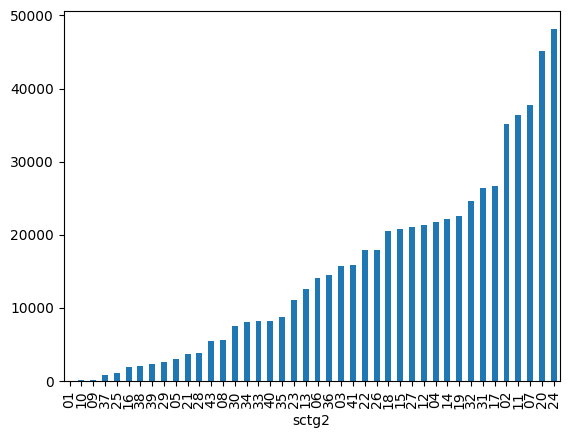

In [50]:
faf_pdf.loc[faf_pdf['dms_mode']==5].groupby('sctg2')['tons_2022'].sum().sort_values().plot(kind='bar')

In [12]:
faf_pdf['sctg2'].dtype

dtype('O')

In [13]:
faf_pdf.loc[(faf_pdf['dms_mode']==2) &(faf_pdf['sctg2'].isin([36]))]

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,tons_2017,tons_2018,tons_2019,tons_2020,tons_2021,tons_2022,tons_2023,tons_2025,tons_2030,tons_2035,tons_2040,tons_2045,tons_2050,value_2017,value_2018,value_2019,value_2020,value_2021,value_2022,value_2023,value_2025,value_2030,value_2035,value_2040,value_2045,value_2050,current_value_2018,current_value_2019,current_value_2020,current_value_2021,current_value_2022,tmiles_2017,tmiles_2018,tmiles_2019,tmiles_2020,tmiles_2021,tmiles_2022,tmiles_2023,tmiles_2025,tmiles_2030,tmiles_2035,tmiles_2040,tmiles_2045,tmiles_2050


In [10]:
basic_cols = [c for c in faf_pdf.columns if not (c.startswith('tons') or c.startswith('value') or c.startswith('tmiles') or c.startswith('current') or c in ['fr_orig','fr_dest','fr_inmode','fr_outmode'])]
extra_cols = ['tons_2022','tmiles_2022','value_2022']
faf_pdf[[*basic_cols,*extra_cols]].sample(5)

,dms_orig,dms_dest,dms_mode,sctg2,trade_type,dist_band,tons_2022,tmiles_2022,value_2022
273876,452,061,1,32,1,8,0.098212,0.227570,1.609759
2096145,219,131,4,32,3,3,0.000000,0.000000,0.000000
1664686,089,451,5,8,3,8,0.000000,0.000000,0.000000
2274814,487,485,2,36,3,4,0.006332,0.004591,0.079575
1055444,369,441,1,32,2,3,0.300924,0.105810,0.911552


In [13]:
# faf_mode_map = {
#     1:  'Truck',
#     2:	'Rail',
#     3:	'Water',
#     4:	'Air (include truck-air)',
#     5:	'Multiple modes & mail',
#     6:	'Pipeline',
#     7:	'Other and unknown',
#     8:	'No domestic mode',
# }

In [11]:
is_by_truck = faf_pdf['dms_mode']==1 # by truck
faf_truck_pdf = faf_pdf.loc[is_by_truck]
total_road_tons_od_pdf = faf_truck_pdf.groupby(['dms_orig','dms_dest'],as_index=False)[[TARGET_FIELD]].sum()

In [12]:
%%time
# create a (state_orig, county_orig, state_dest, county_dest) => tons map
county_od = defaultdict(float)
for row in total_road_tons_od_pdf.itertuples():
    constituent_orig_counties_map = faf_id_to_county_percent_map[row.dms_orig]
    constituent_dest_counties_map = faf_id_to_county_percent_map[row.dms_dest]
    for (state_orig, county_orig), pct_in_county_orig in constituent_orig_counties_map.items():
        for (state_dest, county_dest), pct_in_county_dest in constituent_dest_counties_map.items():
            county_od[(state_orig, county_orig, state_dest, county_dest)] += getattr(row,TARGET_FIELD)*pct_in_county_orig*pct_in_county_dest

assert abs(total_road_tons_od_pdf[TARGET_FIELD].sum()-sum(county_od.values()))<TOLERANCE

CPU times: total: 7.5 s
Wall time: 7.51 s


In [13]:
len(county_od)

9880444

In [26]:
county_od_tuples = [(*k, v) for k,v in county_od.items()]

In [27]:
county_od_pdf = pd.DataFrame(county_od_tuples,columns=['state_orig','county_orig','state_dest','county_dest','tons'])

In [28]:
county_od_pdf.describe()

,tons
count,9.835245e+06
mean,1.287026e+00
std,7.544484e+01
min,0.000000e+00
25%,1.947237e-03
50%,1.113167e-02
75%,6.795850e-02
max,8.937358e+04


In [19]:
county_od_pdf['tons'].quantile(.98)

5.305011000119845

In [20]:
non_zero_county_od_pdf = county_od_pdf.loc[county_od_pdf['tons']>0].sort_values('tons')

In [21]:
non_zero_county_od_pdf['cum_tons'] = non_zero_county_od_pdf['tons'].cumsum()

<Axes: >

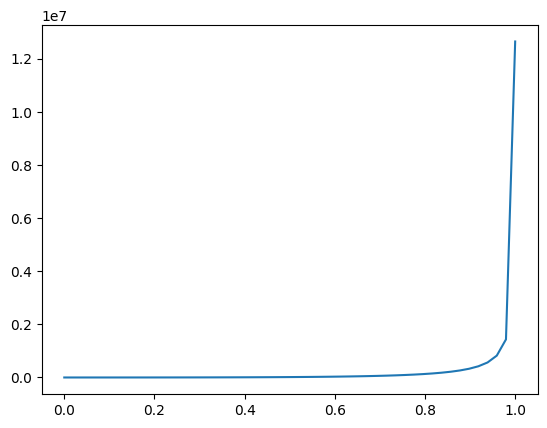

In [22]:
non_zero_county_od_pdf['cum_tons'].quantile(q=np.linspace(0,1,50)).plot()

In [27]:
# save as a parquet file to reduce file size
target_path = CACHE_PATH / 'data/transformed/county_od.parquet'
Path(os.path.dirname(target_path)).mkdir(parents=True,exist_ok=True)
county_od_pdf.to_parquet(target_path)